**Authors:** Elias Köhnlein and Petr Samodelkin, Uni-Heidelberg, Summer Semester 2024



# Re-implementation of the Gaussian elimination algorithm and its applications in *Sage*  



*SageMath* is a powerful tool: it has _a lot_ already built in, and allows you to program on top of that. We are going to showcase both by partly re\-implementing a few linear algebra applications.



## The Gaussian elimination algorithm



The Gaussian elimination algorithm transforms a given matrix to a special form. But first, a linear equation system interlude:
We start with a field $K$ and elements which we'll call numbers in it. We can add, subtract, multiply and divide.
A system of linear equations means we have to substitute numbers from $K$ to satisfy every equation of the form:

\begin{align}
a_{11}x_{1}+a_{12}x_{2}\dots+ a_{1n}x_{n}& =b_{1} \\
a_{21}x_{1}+a_{22}x_{2}\dots+a_{2n}x_{n}  & = b_{2} \\
\dots
\end{align}

To solve it, we first make a few observations:

Observation 1: dropping plus signs and variables preserves information, if we order the variables in every equation first.

Observation 2: if we do one of the elementary operations, namely

a\) swap the rows

b\) add one row to the other

c\) multiply one row by a factor

then the solutions remain the same, which is easy to check. \(Obviously, solutions of the initial system are solutions of the changed one. But inverses of elementary operations are also elementary, so solutions of the changed one are the solutions of the initial one\).

That leads to the Gaussian elimination: an algorithm, that uses elementary operations to bring a matrix to a desirable \(echelon\) form, namely:

We're going to reduce the matrix to the echelon form, like a staircase.
We take the first non-0 column in the matrix, and swap the rows to make sure the top entry in that column isn't 0. Here's basic running through columns.
Then eliminate everything in the column below and above by adding our row, factored first. Repeat for every row. You can see here, why adding rows doesn't mess up the structure: by construction, 0's are to the left.
We're done! You can substitute anything for non-pivot variables, and you'll have exactly one easily obtainable solution per substituted set, it's as easy as moving the free variable entries to the right and adding up. 



### Source code


In [3]:
def gaussian_elimination_sage(A):
    M = Matrix(A)  # Convert list of lists A into a Sage matrix if not already a matrix
    num_rows, num_cols = M.nrows(), M.ncols()

    for row in range(num_rows):
        pivot_col = -1

        for col in range(num_cols):
            for i in range(row, num_rows):
                if M[i, col] != 0:
                    pivot_col = col
                    M.swap_rows(row, i)  # Swap to move pivot to the current row
                    break
            if pivot_col >= 0:
                break  

        if pivot_col == -1:
            return M

        pivot = M[row, pivot_col]
        for i in range(row + 1, num_rows):
            if M[i, pivot_col] != 0:
                factor = M[i, pivot_col] / pivot 
                M.add_multiple_of_row(i, row, -factor)

    return M

def full_gaussian_elimination_sage(A):
    M = Matrix(A) 
    num_rows, num_cols = M.nrows(), M.ncols()

    for row in range(min(num_rows, num_cols)):
        pivot_col = -1

        for col in range(num_cols):
            for i in range(row, num_rows):
                if M[i, col] != 0:
                    pivot_col = col
                    M.swap_rows(row, i)  
                    break
            if pivot_col >= 0:
                break  

        if pivot_col == -1:
            return M
        # show(M)
        
        pivot = M[row, pivot_col]
        M.rescale_row(row, 1 / pivot)

        # Eliminate all entries above and below the pivot
        for i in range(num_rows):
            if i != row and M[i, pivot_col] != 0:
                factor = M[i, pivot_col]
                M.add_multiple_of_row(i, row, -factor)

    return M


# Example usage
B = Matrix(QQ, [
    [1,2,3],
    [1,2,4],
    [4,5,6]
])

print("Original Matrix:")
show(B)

# Perform full Gaussian Elimination
rref_matrix = full_gaussian_elimination_sage(B)

print("Reduced Row Echelon Form:")
show(rref_matrix)
print("Sage-implemented Reduced Row Echelon Form:")
show(B.echelon_form())


# Perform Gaussian Elimination
upper_triangular = gaussian_elimination_sage(B)

print("Upper Triangular Form:")
show(upper_triangular)


Original Matrix:


[1 2 3]
[1 2 4]
[4 5 6]

Reduced Row Echelon Form:


[1 0 0]
[0 1 0]
[0 0 1]

Sage-implemented


[1 0 0]
[0 1 0]
[0 0 1]

Upper Triangular Form:


[ 1  2  3]
[ 0 -3 -6]
[ 0  0  1]

## The Gaussian elimination: user input cell 



In [0]:
#function version test 

# Input matrix from the user
print("Enter the elements of the matrix separated by spaces (row-wise):")
rows = int(input("Enter the number of rows: "))
cols = int(input("Enter the number of columns: "))
print("Enter the elements:")
A = []
for i in range(rows):
    row = list(map(int, input().split()))
    if len(row) != cols:
        print("Number of elements in each row should be equal to the number of columns.")
        exit()  # Terminates the program if the input is invalid
    A.append(row)

# Convert the list of lists to a Sage matrix
B = Matrix(QQ, A)

print("Original Matrix:")
print(B)

# Perform full Gaussian Elimination
rref_matrix = full_gaussian_elimination_sage(B)

print("Reduced Row Echelon Form:")
print(rref_matrix)
print("Sage-implemented")
show(B.echelon_form())


# Perform Gaussian Elimination
upper_triangular = gaussian_elimination_sage(B)

print("Upper Triangular Form:")
print(upper_triangular)


## Finding the inverse of a matrix



Yet another fun observation: if we insert another column on the right to our system,  $(a_{1\ n+1}, a_{2\ n+1} \dots)^{T}$, the algorithm will treat it exactly as the previous column: after reducing the matrix to the echelon form, the column will have the solutions of the equation system with the same coefficients, but with different values, namely $(a_{1\ n+1}, a_{2\ n+1} \dots)^{T}$, to the right of the "=".  Which means, we can solve any number of linear equation systems with the same coefficients at once. 
Since with one vector to the right, system solves $Ax=b$, then with many vectors to the right, we'll be able to solve to $AX=B$, where $B$ has several columns. If we realise only $A^{-1}$ solves $AX=I$, there's our algorithm to find the inserve! A pretty magic one.
$$
\left(
\begin{array}{cccc|ccc}
a_{11} & a_{12} & \dots  & a_{1n}  &  &   \\
 &  & \dots &  &    &  \Huge{I} \\
a_{m1} & a_{m2} & \dots  & a_{mn} & &  &   \\
\end{array}
\right) \underbrace{ \rightarrow }_{ \text{Gaussian elimination} }
\left(
\begin{array}{ccc|ccc}
  & \\
 &  \Huge{I} &  &  & \Huge{A^{-1}}  &  \\
 &  &  &  & 
\end{array}
\right)
$$



In [0]:
B = matrix(QQ, [
    [1, 2,3],
    [1, 0, -1],
    [0, 2, 0]
])
def bad_inverse(B):
    M=matrix(B)
    M = M.augment(matrix.identity(M.nrows()))
    print("Adding I to the right")
    show(M)
    M = full_gaussian_elimination_sage(M)
    print("Look what's on the right in echelon form!")
    show(M)
    return M[:, M.nrows():]

def inverse(B):
    M=matrix(B)
    M = M.augment(matrix.identity(M.nrows()))
    M = full_gaussian_elimination_sage(M)
    return M[:, M.nrows():]


bad_inverse(B)
print("The default method agrees:")
show(B^(-1))


# Finding the column span of the matrix

If we continue our wonderful streak of observations, we can make another one: elementary operations don't change the linear independence of vectors, because every linear combination of them corresponds to one solution of the linear equation, which don't change as we've shown. It's easy to see how non-zero rows in echelon form are linearly interdependent, which means, you can take column vectors of the pivot elements in the initial matrix, they form a basis of it's space! 
$$
\alpha_{1}\begin{pmatrix}
a_{12} \\
a_{21} \\
\dots
\end{pmatrix} + \alpha_{2}\begin{pmatrix}
a_{21} \\
a_{22} \\
\dots
\end{pmatrix} \dots  =\begin{pmatrix}
0 \\
0 \\
\dots
\end{pmatrix} \qquad \leftrightarrow \qquad
A\cdot \begin{pmatrix}
\alpha_{1} \\
\alpha_{2}  \\
\dots 
\end{pmatrix} = 0
$$



In [15]:
def column_basis(B):
    M = Matrix(B)
    echelon = full_gaussian_elimination_sage(Matrix(B))
    independent_columns = []
    show(echelon)
    # Find first non-zero element in each row
    for row in range(echelon.nrows()):
        for col in range(echelon.ncols()):
            if echelon[row, col] != 0:
                independent_columns.append(M.column(col))
                break
    return matrix(M.base_ring(), independent_columns).transpose()

# Example usage:
B = Matrix(QQ, [
    [1, 1, 1],
    [0, 0, 3],
    [1, 1, 2]
])
show(B)
independent_columns_matrix = column_basis(B)
show(independent_columns_matrix)

# one command in Sage?
show(B.column_space())

B.column_space()

[1 1 1]
[0 0 3]
[1 1 2]

[1 1 0]
[0 0 1]
[0 0 0]

[1 1]
[0 3]
[1 2]

Vector space of degree 3 and dimension 2 over Rational Field
Basis matrix:
[  1   0   1]
[  0   1 1/3]


# Calculating the determinant



Another intersting application for the Gauß algorithm is to find the determinant of an matrix.

The steps are:

1. Start with a square matrix.

2. Use Gaussian elimination to transform the matrix into upper triangular form, while keeping track of any row swaps.

3. Multiply the diagonal elements of the upper triangular matrix.

4. If you swapped rows during Gaussian elimination, multiply the result by \-1 for each swap.

5. The final result is the determinant of the original matrix.

Important to note: If we multiply a certain row or column of a matrix 𝐴 by some scalar 𝜆 \-&gt; then determinant of 𝐴 changes to 𝜆|𝐴|.


In [0]:
def determinant_with_gaussian_elimination(A):
    M = Matrix(A)  # Convert list of lists A into a Sage matrix if not already a matrix
    num_rows, num_cols = M.nrows(), M.ncols()
    
    # Check if the matrix is square
    if num_rows != num_cols:
        raise ValueError("Oh dear, it appears you've given me a non-square matrix. How disappointing! I thought you knew better than that. Don't you realize the basic requirement for calculating determinants? Let's try again with a square matrix, shall we?")
        
    det = 1

    for row in range(num_rows):
        pivot_col = -1

        for col in range(num_cols):
            for i in range(row, num_rows):
                if M[i, col] != 0:
                    pivot_col = col
                    M.swap_rows(row, i)  # Swap to move pivot to the current row
                    break
            if pivot_col >= 0:
                break

        if pivot_col == -1:
            return 0  # If the matrix is singular, determinant is zero

        pivot = M[row, pivot_col]
        det *= pivot  # Multiply by pivot element

        for i in range(row + 1, num_rows):
            if M[i, pivot_col] != 0:
                factor = M[i, pivot_col] / pivot
                M.add_multiple_of_row(i, row, -factor)

    return det


# Example usage:
B = Matrix(QQ, [
    [2, 3, 1],
    [0, 2, 4],
    [2, 6, 10],
])


print("Original Matrix:")
show(Matrix(B))

# Perform Gaussian Elimination
upper_triangular = gaussian_elimination_sage(B)

print("Upper Triangular Form:")
show(upper_triangular)


# Calculate determinant using Gaussian elimination
det = determinant_with_gaussian_elimination(B)
print("Determinant by our Algorithm:", det)


print("Determinant by Sage:", B.det())

<span style='font-family:Arial'><span style='font-size:medium'>CODE TO FIND THE BASIS OF A VECTROSPACE FROM GIVEN VECTORS IN 2D</span></span>

<span style='font-size:medium'><span style='font-family:Arial'>In this code snippet, we delve into the concept of vector spaces and showcase the application of Gaussian elimination to find the basis vectors of a given vector space.</span></span>

<span style='font-size:medium'><span style='font-family:Arial'>Objective:</span></span>

<span style='font-size:medium'><span style='font-family:Arial'>\-Gain insight into vector spaces and their basis vectors.</span></span>

<span style='font-size:medium'><span style='font-family:Arial'>\-Utilize Gaussian elimination to simplify matrices and identify basis vectors.</span></span>

<span style='font-size:medium'><span style='font-family:Arial'>\-Visualize the original vectors and their basis vectors in a 2D space.</span></span>

<span style='font-size:medium'><span style='font-family:Arial'>Key Steps:</span></span>

<span style='font-size:medium'><span style='font-family:Arial'>Define the original vectors v1, v2, and v3.</span></span>

<span style='font-size:medium'><span style='font-family:Arial'>Construct a matrix A using these vectors.</span></span>

<span style='font-size:medium'><span style='font-family:Arial'>Perform Gaussian elimination on matrix A to obtain its row echelon form.</span></span>

<span style='font-size:medium'><span style='font-family:Arial'>Extract the basis vectors from the row echelon form.</span></span>

<span style='font-size:medium'><span style='font-family:Arial'>Plot the original vectors and their basis vectors on a 2D graph using matplotlib.</span></span>



Original matrix:


[1 2]
[2 3]
[1 1]


Matrix after Gaussian elimination:


[1 0]
[0 1]
[0 0]


Basis of the vector space:


(1, 0)

(0, 1)

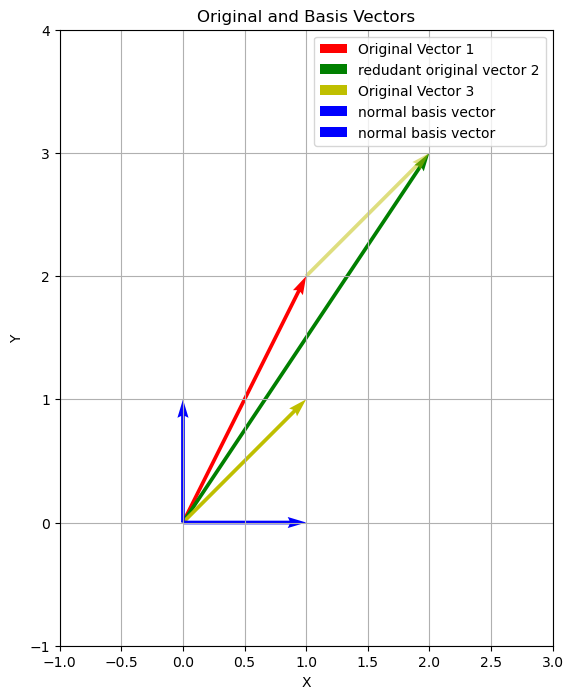

In [1]:
import matplotlib.pyplot as plt
from sage.modules.free_module_element import vector
from sage.plot.arrow import arrow2d

# Define the vectors
v1 = vector([1, 2])
v2 = vector([2, 3])
v3 = vector([1, 1])

# Create a matrix from the vectors
A = matrix([v1, v2, v3])

# Print the original matrix
print("Original matrix:")
show(A)

# Perform Gaussian elimination
A_rref = A.echelon_form()

# Print the matrix after Gaussian elimination
print("\nMatrix after Gaussian elimination:")
show(A_rref)

# Extract the basis vectors from the row echelon form
basis_vectors = [A_rref.row(i) for i in range(A_rref.nrows()) if A_rref.row(i).norm() != 0]

# Print the basis vectors
print("\nBasis of the vector space:")
for vec in basis_vectors:
    show(vec)

# Plot the original vectors and the basis vectors

# Create a figure
plt.figure(figsize=(8, 8))

# Plot original vectors
plt.quiver(0, 0, v1[0], v1[1], angles='xy', scale_units='xy', scale=1, color='r', label='Original Vector 1')
plt.quiver(0, 0, v2[0], v2[1], angles='xy', scale_units='xy', scale=1, color='g', label='redudant original vector 2')
plt.quiver(0, 0, v3[0], v3[1], angles='xy', scale_units='xy', scale=1, color='y', label='Original Vector 3')
plt.quiver(v1[0], v1[1], v3[0], v3[1], angles='xy', scale_units='xy', scale=1, color='y', alpha=0.5)

# Plot basis vectors
for v in basis_vectors:
    plt.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', scale=1, color='b', label='normal basis vector')
    
# Set plot limits and labels
plt.xlim([-1, 3])
plt.ylim([-1, 4])
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.grid(True)
plt.title("Original and Basis Vectors")

# Show the plot
plt.show()


TEST AREA
--------

In [0]:
import numpy as np

# Define the coefficients matrix (left-hand side of the equations)
coefficients = np.array([[3, 2, 9],
                         [1, 2, 0],
                         [0, 2, 20]], dtype=float)

# Define the constants vector (right-hand side of the equations)
constants = np.array([13, 4, 6], dtype=float)

# Solve the system of equations using Gauss elimination method
def gauss_elimination(coefficients, constants):
    n = len(constants)
    
    # Forward elimination
    for i in range(n):
        pivot_row = coefficients[i]
        pivot_elem = pivot_row[i]
        
        for j in range(i+1, n):
            factor = coefficients[j][i] / pivot_elem
            coefficients[j] -= factor * pivot_row
            constants[j] -= factor * constants[i]
    
    # Back substitution
    solution = np.zeros(n)
    for i in range(n-1, -1, -1):
        solution[i] = (constants[i] - np.dot(coefficients[i][i+1:], solution[i+1:])) / coefficients[i][i]
    
    return solution

solution = gauss_elimination(coefficients, constants)
print("Solution:", solution)

verification = np.allclose(np.dot(coefficients, solution), constants)
print("Verification:", verification)


In [0]:
import numpy as np

# Define the coefficients matrix (left-hand side of the equations)
coefficients = np.array([[3, 2, 9],
                         [1, 2, 0],
                         [0, 2, 20]], dtype=float)

# Define the constants vector (right-hand side of the equations)
constants = np.array([13, 4, 6], dtype=float)

# Define the variables names
variables = ['apples', 'bananas', 'cherries']

# Solve the system of equations using Gauss elimination method
def gauss_elimination(coefficients, constants):
    n = len(constants)
    
    # Forward elimination
    for i in range(n):
        pivot_row = coefficients[i]
        pivot_elem = pivot_row[i]
        
        for j in range(i+1, n):
            factor = coefficients[j][i] / pivot_elem
            coefficients[j] -= factor * pivot_row
            constants[j] -= factor * constants[i]
    
    # Back substitution
    solution = np.zeros(n)
    for i in range(n-1, -1, -1):
        solution[i] = (constants[i] - np.dot(coefficients[i][i+1:], solution[i+1:])) / coefficients[i][i]
    
    return solution

# Function to print out the matrices
def show(coefficients, constants, variables):
    print("Equations Matrix:")
    for i in range(len(coefficients)):
        equation = " + ".join([f"{coefficients[i][j]}{variables[j]}" for j in range(len(coefficients[i]))])
        print(equation, "=", constants[i])

# Print the example for the user
print("Example Linear Equation System:")
print("3apples + 2bananas + 9cherries = 13")
print("1apple + 2bananas = 4")
print("2bananas + 20cherries = 6\n")

# Show the equations in matrix form
show(coefficients, constants, variables)
print()

# Solve the system
solution = gauss_elimination(coefficients, constants)
print("\nSolution:")
for i in range(len(solution)):
    print(f"{variables[i]} = {solution[i]}")

# Verification
verification = np.allclose(np.dot(coefficients, solution), constants)
print("\nVerification:", verification)


In [0]:
import numpy as np

# Define the coefficients matrix (left-hand side of the equations)
coefficients = np.array([[3, 2, 9],
                         [1, 2, 0],
                         [0, 2, 20]], dtype=float)

# Define the constants vector (right-hand side of the equations)
constants = np.array([13, 4, 6], dtype=float)

# Define the variables names
variables = ['apples', 'bananas', 'cherries']

# Show function to display the matrices
def show(coefficients, constants, variables):
    print("Original Matrix:")
    for i in range(len(coefficients)):
        equation = " + ".join([f"{coefficients[i][j]}{variables[j]}" for j in range(len(coefficients[i]))])
        equation += f" = {constants[i]}"
        print(equation)

# Print the example for the user
print("Example Linear Equation System:")
print("3apples + 2bananas + 9cherries = 13")
print("1apple + 2bananas = 4")
print("2bananas + 20cherries = 6\n")

# Show the equations in matrix form
show(coefficients, constants, variables)
print()

# Solve the system of equations using Gauss elimination method
n = len(constants)
for i in range(n):
    pivot_row = coefficients[i]
    pivot_elem = pivot_row[i]
    
    for j in range(i+1, n):
        factor = coefficients[j][i] / pivot_elem
        coefficients[j] -= factor * pivot_row
        constants[j] -= factor * constants[i]

# Back substitution
solution = np.zeros(n)
for i in range(n-1, -1, -1):
    solution[i] = (constants[i] - np.dot(coefficients[i][i+1:], solution[i+1:])) / coefficients[i][i]

# Print the solution
print("\nSolution:")
for i in range(len(solution)):
    print(f"{variables[i]} = {solution[i]}")

# Verification
verification = np.allclose(np.dot(coefficients, solution), constants)
print("\nVerification:", verification)



In [8]:
import numpy as np

# Define the coefficients matrix (left-hand side of the equations)
coefficients = np.array([[3, 2, 9],
                         [1, 2, 0],
                         [0, 2, 20]], dtype=float)

# Define the constants vector (right-hand side of the equations)
constants = np.array([13, 4, 6], dtype=float)

# Define the variables names
variables = ['apples', 'bananas', 'cherries']


# Print the example for the user
print("Example Linear Equation System:")
print("3apples + 2bananas + 9cherries = 13")
print("1apple + 2bananas = 4")
print("2bananas + 20cherries = 6\n")


print("The Equations are now looking like Matrix, don't they ?:")

for i in range(len(coefficients)):
    equation = " ".join([f"{coefficients[i][j]}{variables[j]}" for j in range(len(coefficients[i]))])
    equation += f" = {constants[i]}"
    print(equation)
print("\n")
#WHY THE FUCK IS THIS NOT WORKING; 
coe = Matrix(coefficients)
con = Matrix(constants)
Q = coe.augment(con, subdivide = "True")
show(Q) #subdivdie here withe the constants




# Solve the system of equations using Gauss elimination method
n = len(constants)
for i in range(n):
    pivot_row = coefficients[i]
    pivot_elem = pivot_row[i]
    
    for j in range(i+1, n):
        factor = coefficients[j][i] / pivot_elem
        coefficients[j] -= factor * pivot_row
        constants[j] -= factor * constants[i]

# Back substitution
solution = np.zeros(n)
for i in range(n-1, -1, -1):
    solution[i] = (constants[i] - np.dot(coefficients[i][i+1:], solution[i+1:])) / coefficients[i][i]

    
    
    
# Print the solution
print("\nSolution:")
for i in range(len(solution)):
    print(f"{variables[i]} = {solution[i]}")

# Verification
verification = np.allclose(np.dot(coefficients, solution), constants)
print("\nVerification:", verification)


Example Linear Equation System:
3apples + 2bananas + 9cherries = 13
1apple + 2bananas = 4
2bananas + 20cherries = 6

The Equations are now looking like Matrix, don't they ?:
3.0apples 2.0bananas 9.0cherries = 13.0
1.0apples 2.0bananas 0.0cherries = 4.0
0.0apples 2.0bananas 20.0cherries = 6.0




ValueError: need more than 1 value to unpack